In [1]:
# Gerekli Olan Python Paketlerini Colab Ortamına Yükle
!pip install neuralforecast statsforecast datasetsforecast #hyperopt
#https://nixtlaverse.nixtla.io/neuralforecast/examples/getting_started_complete.html#4-train-multiple-models-for-many-series

In [2]:
import pandas as pd #CSV Veri Okutmak ve Veri manipülasyonu için R'daki DataFrame'in karşılığı
import numpy as np #

from neuralforecast import NeuralForecast # Ana Paketimiz
from neuralforecast.auto import AutoNHITS, AutoLSTM #, AutoRNN, AutoNBEATS, AutoDeepAR #Modellerin Otomatik Versiyonları
from neuralforecast.losses.pytorch import MQLoss, MAE #MQLoss Probabilistic Tahmin yapmak için, 80-90 Confidence Aralığında tahmin yapması için

from ray import tune # Hyperparameter Optimization yani Tuning yapan Library
from ray.tune.search.hyperopt import HyperOptSearch # Tuning Search Algoritması

path = 'KRDMD_data.csv'#'usdtry.csv' #Bu dosayayı yandaki dosya yükleme alanına sürükleyip bırakıyoruz
data = pd.read_csv(path, parse_dates=['Date'])
data.head() # verimiz klasick OHLC ve Volume Adjusted formatında

,Date,Id,Open,High,Low,Close,Volume,Adjusted
0,2017-01-02,0,1.15,1.15,1.14,1.15,8952995,1.15
1,2017-01-03,0,1.15,1.16,1.13,1.14,42792000,1.14
2,2017-01-04,0,1.14,1.14,1.11,1.12,31016884,1.12
3,2017-01-05,0,1.12,1.14,1.11,1.13,58083932,1.13
4,2017-01-06,0,1.13,1.14,1.13,1.14,7313235,1.14


In [3]:
data = data[['Date','Id','Close']] #Verideki bu Üç Kolonu seçiyoruz

In [4]:
# Kullandığımız NeuralForecast paketinin kendi kriteri, veriyi bu kolon isimleri ile istiyor tarih ds, target y, bir de unique_id olacak
#o yüzden yeniden isimlendiriyoruz
data = data.rename(columns={'Date': 'ds', 'Close': 'y', 'Id': 'unique_id'})

In [5]:
data.head() # Veriyi Kontrol Edelim

,ds,unique_id,y
0,2017-01-02,0,1.15
1,2017-01-03,0,1.14
2,2017-01-04,0,1.12
3,2017-01-05,0,1.13
4,2017-01-06,0,1.14


In [6]:
train = data.loc[data['ds'] <= '2022-12-31'] # 2023 öncesi veriyi Training Data olarak seçiyoruz
valid = data.loc[(data['ds'] > '2023-01-01') & (data['ds'] < '2024-02-06')] #2023 Sonrasını Holdout set, Out-of-Sample için tutuyoruz

h = valid['ds'].nunique() # Ne kadar adet veriyi valiation için ayırdık onu saydırıyoruz
h # sonra bunu parametre olarak kullanıp bu sayı kadar ilerisi için tahmin yaptırıcaz

270

In [7]:
train.head()

,ds,unique_id,y
0,2017-01-02,0,1.15
1,2017-01-03,0,1.14
2,2017-01-04,0,1.12
3,2017-01-05,0,1.13
4,2017-01-06,0,1.14


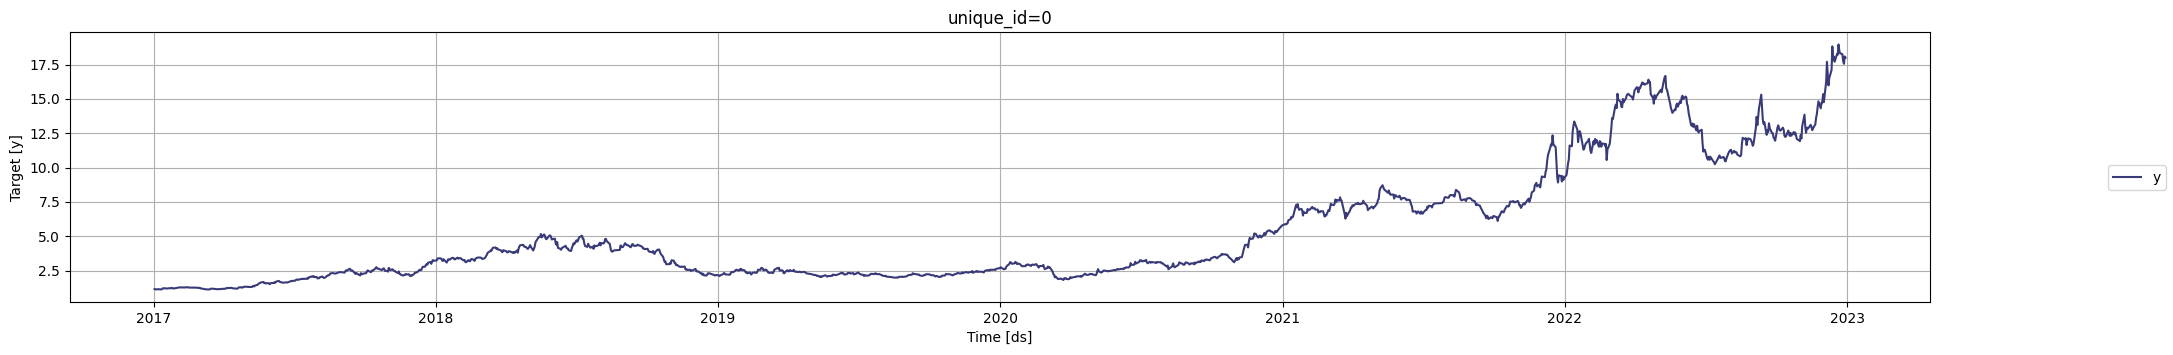

In [8]:
from statsforecast import StatsForecast #Grafik için plot fonksiyonun olduğu paketi import edelim

StatsForecast.plot(train, engine='matplotlib') #Çizdirelim

In [9]:
nhits_config = {
       "max_steps": 100,                                                         # Number of SGD steps
       "input_size": tune.choice([h, h*2]),                                 # Size of input window
       "learning_rate": tune.loguniform(1e-5, 1e-1),                             # Initial Learning rate
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1], [2, 1, 1]]), # Interpolation expressivity ratios
       "val_check_steps": 50,                                                    # Compute validation every 50 steps
       "random_seed": tune.randint(1, 10),                                       # Random seed
    }

In [10]:
AutoNHITS.default_config

{'input_size_multiplier': [1, 2, 3, 4, 5],
 'h': None,
 'n_pool_kernel_size': <ray.tune.search.sample.Categorical at 0x7b1833faadd0>,
 'n_freq_downsample': <ray.tune.search.sample.Categorical at 0x7b1833faae90>,
 'learning_rate': <ray.tune.search.sample.Float at 0x7b1833faaef0>,
 'scaler_type': <ray.tune.search.sample.Categorical at 0x7b1833faafb0>,
 'max_steps': <ray.tune.search.sample.Float at 0x7b1833faaf50>,
 'batch_size': <ray.tune.search.sample.Categorical at 0x7b1833fab130>,
 'windows_batch_size': <ray.tune.search.sample.Categorical at 0x7b1833fab1c0>,
 'loss': None,
 'random_seed': <ray.tune.search.sample.Integer at 0x7b1833fab250>}

In [11]:
horizon = h

model = AutoNHITS(h = horizon, # Horizon Sayısı ileri tarihli kaç günlük tahmin isteniyor
                  loss = MQLoss(), # Probabilistic Tahmin Yapmak için, normal yapmak için MAE() MAPE() vs.
                  config=None,
                  #config = nhits_config,
                  search_alg = HyperOptSearch(), #bunları yukarda import etmiştik şimdi kullanıyorz
                  backend = 'ray',
                  num_samples = 20) #deneme yapma sayısı en az 20 ve üzeri tavsiye ediliyor

In [12]:
# Parametreler
# https://nixtlaverse.nixtla.io/neuralforecast/models.html

In [13]:
nf = NeuralForecast(models=[model], freq='D') # NeuralForecast Objesini oluştur ve istediğimiz modellerin listesini veriyoruz
nf.fit(df=train, val_size=h) #Modeli fit() methoduyla veri ile train et, cross validation için ayrılması gereken veri miktarını belirle

2024-02-11 16:52:50,001	INFO worker.py:1724 -- Started a local Ray instance.
2024-02-11 16:52:51,910	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2024-02-11 16:52:51,917	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-02-11_16-52-45   |
+--------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                   |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 20                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-02-11_16-52-45
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_train_tune_2024-02-11_16-52-45`


(_train_tune pid=11965) Seed set to 11
(_train_tune pid=11965) 2024-02-11 16:53:12.964868: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=11965) 2024-02-11 16:53:12.964933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=11965) 2024-02-11 16:53:12.966996: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_train_tune pid=11965) 2024-02-11 16:53:14.339744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 37.14it/s, v_num=0, train_loss_step=1.32e+4, train_loss_epoch=1.54e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 40.37it/s, v_num=0, train_loss_step=925.0, train_loss_epoch=1.18e+3, valid_loss=2.18e+3]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s, v_num=0, train_loss_step=880.0, train_loss_epoch=884.0, valid_loss=850.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s, v_num=0, train_loss_step=347.0, train_loss_epoch=339.0, valid_loss=3.24e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 40.59it/s, v_num=0, train_loss_step=363.0, train_loss_epoch=345.0, valid_loss=4.43e+3]
(_train_tune pid=11965) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=11965) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train

2024-02-11 16:53:41,383	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (40, 20, 1), 'n_pool_kernel_size': (1, 1, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 899: 100%|██████████| 1/1 [00:00<00:00, 36.66it/s, v_num=0, train_loss_step=175.0, train_loss_epoch=152.0, valid_loss=4.58e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 899: 100%|██████████| 1/1 [00:00<00:00, 21.63it/s, v_num=0, train_loss_step=175.0, train_loss_epoch=175.0, valid_loss=4.62e+3]


(_train_tune pid=11965) Seed set to 3
2024-02-11 16:53:41,988	ERROR tune_controller.py:1374 -- Trial task failed for trial _train_tune_a07ed9da
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2626, in get
    raise value
ray.exceptions.RayActorError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: 8b6747bcfd26b0f3c650d5a601000000
	pid: 11965
	namespace: 5648b071-e50c-40bf-9a5f-745b9a4e46aa
	ip: 172.28.0.12
The actor is dead because its worker process has 

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 
(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1807, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1908, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1813, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1754, in ray._raylet.execute_task.function_executor
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 726, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/util/tracing/tracing_helper.py", line 467, in _resume_span
    return method(self, *_args, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)
  File "/usr/local/lib/python3.10/dist-packages/ray/air/_internal/util.py", line 88, in run
    self._ret = self._target(*self._args,

(_train_tune pid=12215) Seed set to 7
(_train_tune pid=12215) 2024-02-11 16:53:49.843600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=12215) 2024-02-11 16:53:49.843663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=12215) 2024-02-11 16:53:49.845688: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_train_tune pid=12215) 2024-02-11 16:53:51.510983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s, v_num=0, train_loss_step=0.037, train_loss_epoch=0.0311] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 34.88it/s, v_num=0, train_loss_step=0.0384, train_loss_epoch=0.0359, valid_loss=1.820]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 36.24it/s, v_num=0, train_loss_step=0.0191, train_loss_epoch=0.0178, valid_loss=1.800]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 33.70it/s, v_num=0, train_loss_step=0.0115, train_loss_epoch=0.0092, valid_loss=1.810]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=12215) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.42it/s]
(_train_tune pid=12215) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 38.00it/s, v_num=0, train_loss_step=0.015, train_loss_epoch=0.00986, val

2024-02-11 16:54:27,522	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (180, 60, 1), 'n_pool_kernel_size': (8, 4, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 1099: 100%|██████████| 1/1 [00:00<00:00, 35.43it/s, v_num=0, train_loss_step=0.00354, train_loss_epoch=0.00474, valid_loss=1.820]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1099: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s, v_num=0, train_loss_step=0.00354, train_loss_epoch=0.00354, valid_loss=1.820]


(_train_tune pid=12215) Seed set to 16
2024-02-11 16:54:28,117	ERROR tune_controller.py:1374 -- Trial task failed for trial _train_tune_b3811d5a
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2626, in get
    raise value
ray.exceptions.RayActorError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: da6b397b355ec4aa654c766101000000
	pid: 12215
	namespace: 5648b071-e50c-40bf-9a5f-745b9a4e46aa
	ip: 172.28.0.12
The actor is dead because its worker process has

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 
(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1807, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1908, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1813, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1754, in ray._raylet.execute_task.function_executor
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 726, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/util/tracing/tracing_helper.py", line 467, in _resume_span
    return method(self, *_args, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)
  File "/usr/local/lib/python3.10/dist-packages/ray/air/_internal/util.py", line 88, in run
    self._ret = self._target(*self._args,

(_train_tune pid=12441) Seed set to 19
(_train_tune pid=12441) 2024-02-11 16:54:37.030563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=12441) 2024-02-11 16:54:37.030616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=12441) 2024-02-11 16:54:37.032000: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_train_tune pid=12441) 2024-02-11 16:54:38.169041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 84.75it/s, v_num=0, train_loss_step=2.26e+3, train_loss_epoch=1.95e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 71.37it/s, v_num=0, train_loss_step=845.0, train_loss_epoch=733.0, valid_loss=1.41e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 62.56it/s, v_num=0, train_loss_step=285.0, train_loss_epoch=288.0, valid_loss=1.75e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 94.60it/s, v_num=0, train_loss_step=337.0, train_loss_epoch=331.0, valid_loss=1.88e+4] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 91.85it/s, v_num=0, train_loss_step=147.0, train_loss_epoch=125.0, valid_loss=1.79e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 91.08it/s, v_num=0, trai

2024-02-11 16:54:50,156	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (40, 20, 1), 'n_pool_kernel_size': (16, 8, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=12441) Seed set to 15


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 84.92it/s, v_num=0, train_loss_step=2.12e+4, train_loss_epoch=1.8e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 83.00it/s, v_num=0, train_loss_step=1.11e+4, train_loss_epoch=9.19e+3, valid_loss=5.75e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 83.61it/s, v_num=0, train_loss_step=1.46e+4, train_loss_epoch=1.55e+4, valid_loss=3.86e+4] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.80it/s]
(_train_tune pid=12441) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 35.07it/s, v_num=0, train_loss_step=4.35e+3, train_loss_epoch=4.36e+3, valid_loss=2.91e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 84.18it/s, v_num=0, train_loss_step=4.96e+3, train_loss_epoch=5.82e+3, valid_loss=2.08e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599:

2024-02-11 16:55:05,757	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (40, 20, 1), 'n_pool_kernel_size': (16, 8, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 82.57it/s, v_num=0, train_loss_step=2.74e+3, train_loss_epoch=2.37e+3, valid_loss=2.13e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 36.23it/s, v_num=0, train_loss_step=2.74e+3, train_loss_epoch=2.74e+3, valid_loss=2.09e+4]


(_train_tune pid=12441) Seed set to 14


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 59.69it/s, v_num=0, train_loss_step=0.0663, train_loss_epoch=0.0664]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 35.53it/s, v_num=0, train_loss_step=0.0454, train_loss_epoch=0.0455, valid_loss=0.770]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 59.55it/s, v_num=0, train_loss_step=0.0338, train_loss_epoch=0.0342, valid_loss=0.787]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=12441) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 54.82it/s, v_num=0, train_loss_step=0.0317, train_loss_epoch=0.0305, valid_loss=0.889]
(_train_tune pid=12441) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=12441) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=12441) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 44.13it/s, v_num=0, train_loss_

2024-02-11 16:55:21,796	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (180, 60, 1), 'n_pool_kernel_size': (16, 8, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 799: 100%|██████████| 1/1 [00:00<00:00, 56.07it/s, v_num=0, train_loss_step=0.0238, train_loss_epoch=0.0251, valid_loss=0.976]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 799: 100%|██████████| 1/1 [00:00<00:00, 26.79it/s, v_num=0, train_loss_step=0.0238, train_loss_epoch=0.0238, valid_loss=1.010]


(_train_tune pid=12441) Seed set to 18


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 58.70it/s, v_num=0, train_loss_step=0.0942, train_loss_epoch=0.0928]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 59.33it/s, v_num=0, train_loss_step=0.0744, train_loss_epoch=0.0738, valid_loss=0.687]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 59.41it/s, v_num=0, train_loss_step=0.059, train_loss_epoch=0.060, valid_loss=0.516]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.77it/s]
                                                                       
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 59.07it/s, v_num=0, train_loss_step=0.0517, train_loss_epoch=0.0497, valid_loss=0.644]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 43.56it/s, v_num=0, train_loss_step=0.0449, train_loss_epoch=0.046, valid_loss=0.799]
(_train_tune pid=12441) 
Vali

2024-02-11 16:55:51,947	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (168, 24, 1), 'n_pool_kernel_size': (4, 4, 4), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 1499: 100%|██████████| 1/1 [00:00<00:00, 59.06it/s, v_num=0, train_loss_step=0.0311, train_loss_epoch=0.0313, valid_loss=1.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1499: 100%|██████████| 1/1 [00:00<00:00, 31.67it/s, v_num=0, train_loss_step=0.0311, train_loss_epoch=0.0311, valid_loss=1.020]


(_train_tune pid=12441) Seed set to 11


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.28it/s]
                                                                            
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 35.85it/s, v_num=0, train_loss_step=0.205, train_loss_epoch=0.211]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 33.69it/s, v_num=0, train_loss_step=0.150, train_loss_epoch=0.151, valid_loss=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 31.26it/s, v_num=0, train_loss_step=0.117, train_loss_epoch=0.125, valid_loss=0.781]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 35.72it/s, v_num=0, train_loss_step=0.103, train_loss_epoch=0.106, valid_loss=0.622]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 35.85it/s, v_num=0, train_loss_step=0.0989, train_loss_epoch=0.100, valid_loss=0.593]
(_train_tune pid=12441) 


2024-02-11 16:56:29,275	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (60, 8, 1), 'n_pool_kernel_size': (8, 4, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 1199: 100%|██████████| 1/1 [00:00<00:00, 35.34it/s, v_num=0, train_loss_step=0.0752, train_loss_epoch=0.0756, valid_loss=0.613]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1199: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s, v_num=0, train_loss_step=0.0752, train_loss_epoch=0.0752, valid_loss=0.613]


(_train_tune pid=12441) Seed set to 5


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 43.62it/s, v_num=0, train_loss_step=0.0818, train_loss_epoch=0.0811]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 45.96it/s, v_num=0, train_loss_step=0.0584, train_loss_epoch=0.0546, valid_loss=0.907]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 51.17it/s, v_num=0, train_loss_step=0.0452, train_loss_epoch=0.0515, valid_loss=0.994]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 51.31it/s, v_num=0, train_loss_step=0.040, train_loss_epoch=0.0416, valid_loss=1.000] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 41.61it/s, v_num=0, train_loss_step=0.0348, train_loss_epoch=0.0343, valid_loss=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 50.74it/s, v_num=0, train_loss_step=0.0333, train_loss_epoch=0.0337, valid_los

2024-02-11 16:56:58,881	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (180, 60, 1), 'n_pool_kernel_size': (2, 2, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 1299: 100%|██████████| 1/1 [00:00<00:00, 50.69it/s, v_num=0, train_loss_step=0.0286, train_loss_epoch=0.0291, valid_loss=1.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1299: 100%|██████████| 1/1 [00:00<00:00, 21.16it/s, v_num=0, train_loss_step=0.0286, train_loss_epoch=0.0286, valid_loss=1.020]


(_train_tune pid=12441) Seed set to 4


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 79.11it/s, v_num=0, train_loss_step=49.30, train_loss_epoch=50.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 78.62it/s, v_num=0, train_loss_step=131.0, train_loss_epoch=101.0, valid_loss=25.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 66.47it/s, v_num=0, train_loss_step=35.70, train_loss_epoch=20.60, valid_loss=45.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 65.10it/s, v_num=0, train_loss_step=9.010, train_loss_epoch=6.910, valid_loss=23.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 75.27it/s, v_num=0, train_loss_step=5.210, train_loss_epoch=5.620, valid_loss=24.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 67.19it/s, v_num=0, train_loss_step=5.490, train_loss_epoch=5.340, valid_loss=24.50]
Val

2024-02-11 16:57:15,035	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (1, 1, 1), 'n_pool_kernel_size': (8, 4, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 79.10it/s, v_num=0, train_loss_step=2.630, train_loss_epoch=3.390, valid_loss=27.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 33.37it/s, v_num=0, train_loss_step=2.630, train_loss_epoch=2.630, valid_loss=25.70]


(_train_tune pid=12441) Seed set to 8


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 52.68it/s, v_num=0, train_loss_step=1.24e+9, train_loss_epoch=1.65e+9]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 44.81it/s, v_num=0, train_loss_step=7.17e+7, train_loss_epoch=7.74e+7, valid_loss=2.5e+9]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 53.33it/s, v_num=0, train_loss_step=4.39e+7, train_loss_epoch=3.62e+7, valid_loss=6.72e+8]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 55.60it/s, v_num=0, train_loss_step=3.12e+7, train_loss_epoch=3.13e+7, valid_loss=4.02e+8]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 55.27it/s, v_num=0, train_loss_step=2.88e+7, train_loss_epoch=2.73e+7, valid_loss=4.57e+8]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 55.28it/s, v_num=0, train_loss_step=1.48e+7, train_loss_epoch

2024-02-11 16:57:36,583	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (168, 24, 1), 'n_pool_kernel_size': (2, 2, 2), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 55.45it/s, v_num=0, train_loss_step=7.65e+6, train_loss_epoch=8.46e+6, valid_loss=4.58e+8]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 29.02it/s, v_num=0, train_loss_step=7.65e+6, train_loss_epoch=7.65e+6, valid_loss=3.31e+8]


(_train_tune pid=12441) Seed set to 12


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 97.55it/s, v_num=0, train_loss_step=0.017, train_loss_epoch=0.0181]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 92.75it/s, v_num=0, train_loss_step=0.00683, train_loss_epoch=0.0074, valid_loss=1.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 98.01it/s, v_num=0, train_loss_step=0.00706, train_loss_epoch=0.00575, valid_loss=1.540] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 94.95it/s, v_num=0, train_loss_step=0.00402, train_loss_epoch=0.00447, valid_loss=1.550] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 69.24it/s, v_num=0, train_loss_step=0.00557, train_loss_epoch=0.00581, valid_loss=1.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 31.41it/s, v_num=0, train_loss_step=0.00183, train_loss_epoch=0.0018

2024-02-11 16:57:57,131	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (24, 12, 1), 'n_pool_kernel_size': (4, 4, 4), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 1499: 100%|██████████| 1/1 [00:00<00:00, 78.36it/s, v_num=0, train_loss_step=0.00198, train_loss_epoch=0.00176, valid_loss=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1499: 100%|██████████| 1/1 [00:00<00:00, 29.78it/s, v_num=0, train_loss_step=0.00198, train_loss_epoch=0.00198, valid_loss=1.480]


(_train_tune pid=12441) Seed set to 9
2024-02-11 16:57:57,609	ERROR tune_controller.py:1374 -- Trial task failed for trial _train_tune_28290dbe
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2626, in get
    raise value
ray.exceptions.RayActorError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: ef26e9fb48c7d345e502573101000000
	pid: 12441
	namespace: 5648b071-e50c-40bf-9a5f-745b9a4e46aa
	ip: 172.28.0.12
The actor is dead because its worker process has 

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 
(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1807, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1908, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1813, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1754, in ray._raylet.execute_task.function_executor
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 726, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/util/tracing/tracing_helper.py", line 467, in _resume_span
    return method(self, *_args, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)
  File "/usr/local/lib/python3.10/dist-packages/ray/air/_internal/util.py", line 88, in run
    self._ret = self._target(*self._args,

(_train_tune pid=13363) Seed set to 10
(_train_tune pid=13363) 2024-02-11 16:58:05.899905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=13363) 2024-02-11 16:58:05.899955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=13363) 2024-02-11 16:58:05.901362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_train_tune pid=13363) 2024-02-11 16:58:07.051910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 37.13it/s, v_num=0, train_loss_step=0.0657, train_loss_epoch=0.0644]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.59it/s]
(_train_tune pid=13363) 
                                                                       
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 36.76it/s, v_num=0, train_loss_step=0.0479, train_loss_epoch=0.048, valid_loss=0.836]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 35.29it/s, v_num=0, train_loss_step=0.0345, train_loss_epoch=0.0342, valid_loss=0.651]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 37.13it/s, v_num=0, train_loss_step=0.0327, train_loss_epoch=0.0325, valid_loss=0.679]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 34.82it/s, v_num=0, train_loss_step=0.0267, train_loss_epoch=0.027, valid_loss=0.711]
Val

2024-02-11 16:58:30,238	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (1, 1, 1), 'n_pool_kernel_size': (16, 8, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 699: 100%|██████████| 1/1 [00:00<00:00, 36.99it/s, v_num=0, train_loss_step=0.0253, train_loss_epoch=0.025, valid_loss=0.781]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 699: 100%|██████████| 1/1 [00:00<00:00, 27.97it/s, v_num=0, train_loss_step=0.0253, train_loss_epoch=0.025, valid_loss=0.791]


(_train_tune pid=13363) Seed set to 12


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 91.96it/s, v_num=0, train_loss_step=0.274, train_loss_epoch=0.279] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 89.59it/s, v_num=0, train_loss_step=1.650, train_loss_epoch=14.30, valid_loss=2.230] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 72.49it/s, v_num=0, train_loss_step=0.104, train_loss_epoch=0.105, valid_loss=8.700]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13363) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 58.11it/s, v_num=0, train_loss_step=0.0939, train_loss_epoch=0.0958, valid_loss=1.680]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 87.38it/s, v_num=0, train_loss_step=0.0929, train_loss_epoch=0.0953, valid_loss=1.650] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████

2024-02-11 16:58:42,915	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (1, 1, 1), 'n_pool_kernel_size': (1, 1, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=13363) Seed set to 5


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 33.80it/s, v_num=0, train_loss_step=0.131, train_loss_epoch=0.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 30.98it/s, v_num=0, train_loss_step=0.0872, train_loss_epoch=0.0858, valid_loss=0.829]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 34.51it/s, v_num=0, train_loss_step=0.0724, train_loss_epoch=0.0719, valid_loss=0.907]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 33.31it/s, v_num=0, train_loss_step=0.0595, train_loss_epoch=0.0604, valid_loss=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13363) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 33.41it/s, v_num=0, train_loss_step=0.055, train_loss_epoch=0.0534, valid_loss=1.050] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|        

2024-02-11 16:59:11,984	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (180, 60, 1), 'n_pool_kernel_size': (8, 4, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 899: 100%|██████████| 1/1 [00:00<00:00, 33.98it/s, v_num=0, train_loss_step=0.0448, train_loss_epoch=0.0458, valid_loss=1.130]
(_train_tune pid=13363) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 899: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s, v_num=0, train_loss_step=0.0448, train_loss_epoch=0.0448, valid_loss=1.150]


(_train_tune pid=13363) Seed set to 13


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 50.42it/s, v_num=0, train_loss_step=0.175, train_loss_epoch=0.176]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13363) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 55.74it/s, v_num=0, train_loss_step=0.120, train_loss_epoch=0.122, valid_loss=0.546]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.86it/s]
(_train_tune pid=13363) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 54.25it/s, v_num=0, train_loss_step=0.0898, train_loss_epoch=0.0916, valid_loss=0.825]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 52.97it/s, v_num=0, train_loss_step=0.0797, train_loss_epoch=0.0797, valid_loss=1.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 55.61it/s, v_num=0, train_loss_step=0.0673, train_loss_epoch=0.0675, valid_l

2024-02-11 16:59:42,220	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (168, 24, 1), 'n_pool_kernel_size': (4, 4, 4), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 1399: 100%|██████████| 1/1 [00:00<00:00, 48.69it/s, v_num=0, train_loss_step=0.0486, train_loss_epoch=0.0484, valid_loss=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1399: 100%|██████████| 1/1 [00:00<00:00, 22.06it/s, v_num=0, train_loss_step=0.0486, train_loss_epoch=0.0486, valid_loss=1.060]


(_train_tune pid=13363) Seed set to 9


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 39.63it/s, v_num=0, train_loss_step=0.0117, train_loss_epoch=0.0109]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 39.37it/s, v_num=0, train_loss_step=0.012, train_loss_epoch=0.0112, valid_loss=1.830] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 39.24it/s, v_num=0, train_loss_step=0.00782, train_loss_epoch=0.00557, valid_loss=1.850]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 212.07it/s]
(_train_tune pid=13363) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 36.36it/s, v_num=0, train_loss_step=0.00545, train_loss_epoch=0.00574, valid_loss=1.850]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 39.56it/s, v_num=0, train_loss_step=0.00281, train_loss_epoch=0.00344, valid_loss=1.850]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader

2024-02-11 17:00:22,561	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (24, 12, 1), 'n_pool_kernel_size': (1, 1, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 1399: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s, v_num=0, train_loss_step=0.00128, train_loss_epoch=0.00151, valid_loss=1.860]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1399: 100%|██████████| 1/1 [00:00<00:00, 23.64it/s, v_num=0, train_loss_step=0.00128, train_loss_epoch=0.00128, valid_loss=1.860]


(_train_tune pid=13363) Seed set to 9


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 84.20it/s, v_num=0, train_loss_step=1.750, train_loss_epoch=2.080] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 82.21it/s, v_num=0, train_loss_step=0.704, train_loss_epoch=0.752, valid_loss=2.660]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 82.71it/s, v_num=0, train_loss_step=0.653, train_loss_epoch=0.586, valid_loss=0.591]
(_train_tune pid=13363) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13363) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 67.04it/s, v_num=0, train_loss_step=0.518, train_loss_epoch=0.586, valid_loss=0.562]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 66.44it/s, v_num=0, train_loss_step=0.484, train_loss_epoch=0.531, valid_loss=0.552]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 588:   0%|    

2024-02-11 17:00:31,442	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (60, 8, 1), 'n_pool_kernel_size': (1, 1, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-02-11 17:00:31,472	ERROR tune.py:1038 -- Trials did not complete: [_train_tune_a07ed9da, _train_tune_b3811d5a, _train_tune_28290dbe]


Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 84.34it/s, v_num=0, train_loss_step=0.459, train_loss_epoch=0.472, valid_loss=0.558]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s, v_num=0, train_loss_step=0.459, train_loss_epoch=0.459, valid_loss=0.570]



INFO:lightning_fabric.utilities.seed:Seed set to 9


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [14]:
nf.models[0].config # Kendimiz config belirlemediğimizde (config=None), kendi yaptığı config'in parametrelerinin ne buldugunu gör

{'h': 270,
 'n_pool_kernel_size': <ray.tune.search.sample.Categorical at 0x7b17e6564550>,
 'n_freq_downsample': <ray.tune.search.sample.Categorical at 0x7b17e6565a20>,
 'learning_rate': <ray.tune.search.sample.Float at 0x7b17e6565b40>,
 'scaler_type': <ray.tune.search.sample.Categorical at 0x7b17e6565c60>,
 'max_steps': <ray.tune.search.sample.Float at 0x7b17e6565d20>,
 'batch_size': <ray.tune.search.sample.Categorical at 0x7b17e6565de0>,
 'windows_batch_size': <ray.tune.search.sample.Categorical at 0x7b17e6565ed0>,
 'loss': MQLoss(),
 'random_seed': <ray.tune.search.sample.Integer at 0x7b17e6565fc0>,
 'input_size': <ray.tune.search.sample.Categorical at 0x7b17e6566080>,
 'step_size': <ray.tune.search.sample.Categorical at 0x7b17e6566140>,
 'valid_loss': MQLoss()}

In [15]:
results = nf.models[0].results.get_dataframe() # Farklı Paramerelerle Denediği modellerin ve sonuçlarının listesini al
results.head() # ilk 5 sıradakini göster
#results

,loss,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,...,config/scaler_type,config/max_steps,config/batch_size,config/windows_batch_size,config/loss,config/random_seed,config/input_size,config/step_size,config/valid_loss,logdir
0,4623.978516,1707670421,None,False,9,28eb9b5e,2024-02-11_16-53-41,2.842164,29.169567,11965,...,standard,900.0,64,1024,MQLoss(),11,270,270,MQLoss(),28eb9b5e
1,1.821563,1707670467,None,False,11,d4cc90c7,2024-02-11_16-54-27,2.829439,38.451887,12215,...,standard,1100.0,256,1024,MQLoss(),7,270,270,MQLoss(),d4cc90c7
2,18947.746094,1707670490,None,False,7,b95947ec,2024-02-11_16-54-50,1.366863,13.723864,12441,...,robust,700.0,256,128,MQLoss(),19,540,270,MQLoss(),b95947ec
3,20876.724609,1707670505,None,False,10,57d35312,2024-02-11_16-55-05,1.411386,15.469602,12441,...,standard,1000.0,256,256,MQLoss(),15,1080,1,MQLoss(),57d35312
4,1.011298,1707670521,None,False,8,a241f7d5,2024-02-11_16-55-21,2.026446,15.918543,12441,...,None,800.0,256,512,MQLoss(),14,540,1,MQLoss(),a241f7d5


In [16]:
Y_hat_df = nf.predict() # Tahmini yaptır

Predicting: |          | 0/? [00:00<?, ?it/s]

In [17]:
Y_hat_df.columns = Y_hat_df.columns.str.replace('-median', '') #Median Değer bizim Point Estimate Tahminimiz
Y_hat_df

,ds,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90
unique_id,,,,,,
0,2022-12-31,17.979424,16.766840,17.422056,18.902023,22.773197
0,2023-01-01,18.054958,16.479799,17.250137,19.626118,22.650551
0,2023-01-02,18.082079,16.291702,17.033539,19.695629,22.824142
0,2023-01-03,18.155155,15.939741,16.918602,19.991444,22.790646
0,2023-01-04,18.213215,15.873455,16.707550,20.320122,22.996185
...,...,...,...,...,...,...
0,2023-09-22,39.487198,16.930326,18.459122,58.319107,60.054237
0,2023-09-23,39.319305,16.957253,18.484787,58.119301,59.891319
0,2023-09-24,39.241642,17.009945,18.482903,58.233047,59.926414


In [18]:
Y_hat_df = Y_hat_df.reset_index().set_index('ds') #Tarihi dataframein indexi olarak set ediyoruz

Y_hat_df

,unique_id,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90
ds,,,,,,
2022-12-31,0,17.979424,16.766840,17.422056,18.902023,22.773197
2023-01-01,0,18.054958,16.479799,17.250137,19.626118,22.650551
2023-01-02,0,18.082079,16.291702,17.033539,19.695629,22.824142
2023-01-03,0,18.155155,15.939741,16.918602,19.991444,22.790646
2023-01-04,0,18.213215,15.873455,16.707550,20.320122,22.996185
...,...,...,...,...,...,...
2023-09-22,0,39.487198,16.930326,18.459122,58.319107,60.054237
2023-09-23,0,39.319305,16.957253,18.484787,58.119301,59.891319
2023-09-24,0,39.241642,17.009945,18.482903,58.233047,59.926414


In [19]:
#StatsForecast.plot(train, Y_hat_df[["AutoNHITS"]], engine='matplotlib', max_insample_length=h*2)

In [20]:
Y_hat_df_merged = Y_hat_df.merge(valid[['ds','unique_id', 'y']], on=['ds', 'unique_id'], how='left').dropna(axis=0).set_index('ds')
# tahminlerin bulunduğu dataframe ile validation (hold-out) verimizi birleştiriyoruz, ikisini de graifkte çizdirip üst üste görmek için

Y_hat_df_merged

,unique_id,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,y
ds,,,,,,,
2023-01-02,0,18.082079,16.291702,17.033539,19.695629,22.824142,18.52
2023-01-03,0,18.155155,15.939741,16.918602,19.991444,22.790646,18.81
2023-01-04,0,18.213215,15.873455,16.707550,20.320122,22.996185,19.79
2023-01-05,0,18.228657,15.664571,16.521908,20.514835,22.853027,18.00
2023-01-06,0,18.294952,15.575874,16.355286,20.726627,22.935343,19.26
...,...,...,...,...,...,...,...
2023-09-20,0,39.147865,16.952511,18.519791,58.602180,60.319405,25.60
2023-09-21,0,39.392952,16.937449,18.535725,58.369446,60.080017,26.46
2023-09-22,0,39.487198,16.930326,18.459122,58.319107,60.054237,27.52


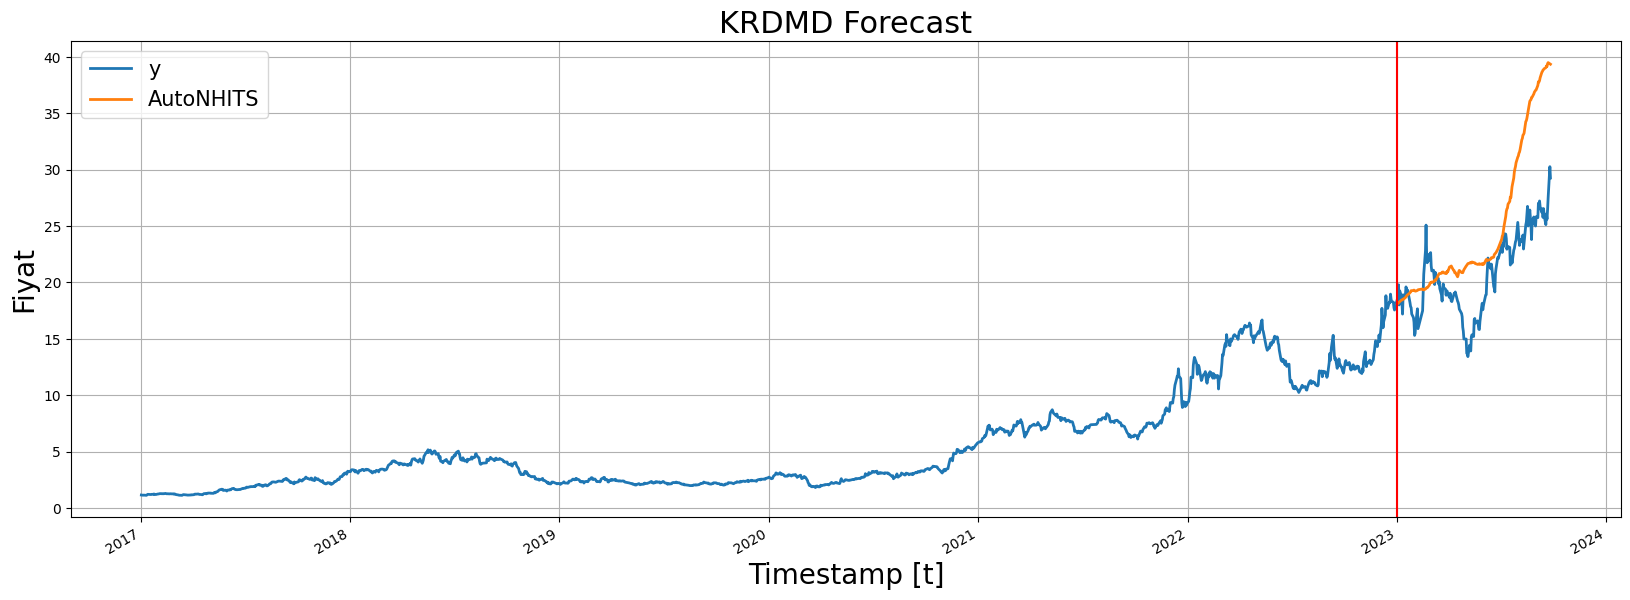

In [21]:
import matplotlib.pyplot as plt

# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plot_df = pd.concat([train.set_index('ds'), Y_hat_df_merged]) # Concatenate the train and forecast dataframes
plot_df[['y', 'AutoNHITS']].plot(ax=ax, linewidth=2)

ax.set_title('KRDMD Forecast', fontsize=22)
ax.set_ylabel('Fiyat', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
plt.axvline('2023-01-01', color='red')

ax.legend(prop={'size': 15})
ax.grid()

#Probabilistic Forecast Plot - CI %80 - %90

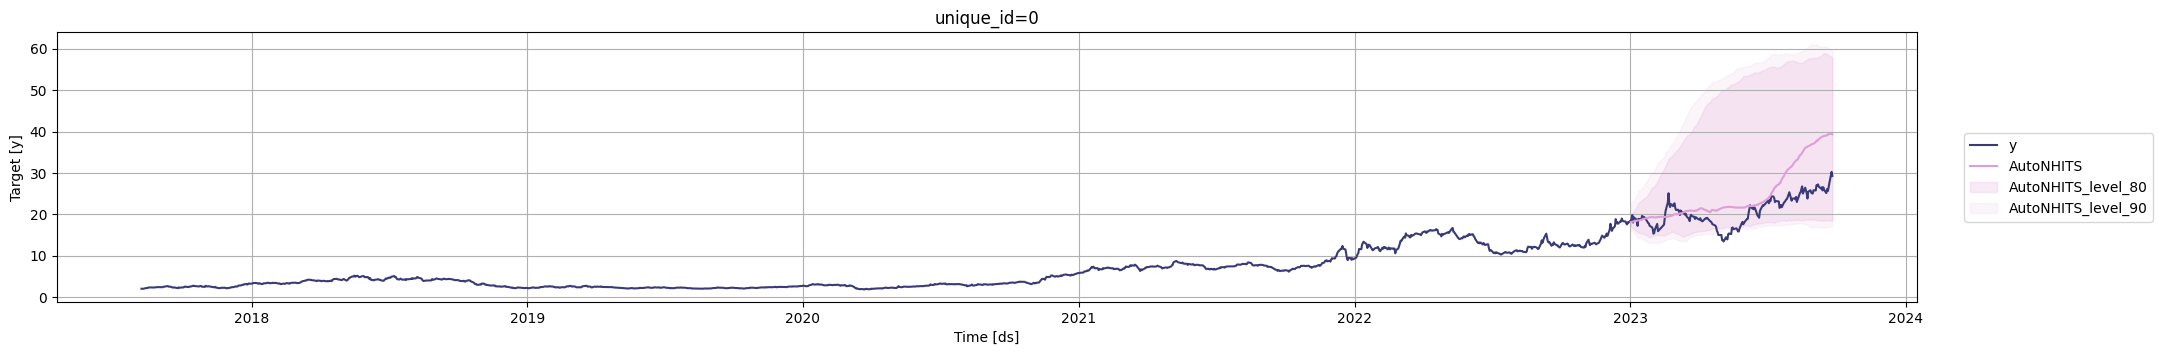

In [22]:
# Plot to unique_ids and some selected models

#StatsForecast.plot(train, Y_hat_df_merged.reset_index(), models=["AutoLSTM"], unique_ids=["0"], level=[80, 90], engine='matplotlib')
StatsForecast.plot(train, Y_hat_df_merged.reset_index(), engine='matplotlib', max_insample_length=h * 5, level=[80, 90])


In [23]:
from datasetsforecast.losses import mse, mae, rmse
from datasetsforecast.evaluation import accuracy

evaluation_df = accuracy(cv_df, [mse, mae, rmse], agg_by=['unique_id'])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df.head()

NameError: name 'cv_df' is not defined